In [31]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [1]:
words = open('names.txt', 'r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
min(len(w) for w in words)

2

In [5]:
max(len(w) for w in words)

15

In [6]:
for w in words[:1]:
    for ch1, ch2 in zip(w, w[1:]):
        print(ch1, ch2)

e m
m m
m a


In [9]:
words[:1]

['emma']

In [7]:
w

'emma'

In [8]:
w[1:]

'mma'

In [12]:
b = {}
for w in words[:3]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [13]:
b

{('<S>', 'e'): 1,
 ('e', 'm'): 1,
 ('m', 'm'): 1,
 ('m', 'a'): 1,
 ('a', '<E>'): 3,
 ('<S>', 'o'): 1,
 ('o', 'l'): 1,
 ('l', 'i'): 1,
 ('i', 'v'): 1,
 ('v', 'i'): 1,
 ('i', 'a'): 1,
 ('<S>', 'a'): 1,
 ('a', 'v'): 1,
 ('v', 'a'): 1}

In [14]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [15]:
b

{('<S>', 'e'): 1531,
 ('e', 'm'): 769,
 ('m', 'm'): 168,
 ('m', 'a'): 2590,
 ('a', '<E>'): 6640,
 ('<S>', 'o'): 394,
 ('o', 'l'): 619,
 ('l', 'i'): 2480,
 ('i', 'v'): 269,
 ('v', 'i'): 911,
 ('i', 'a'): 2445,
 ('<S>', 'a'): 4410,
 ('a', 'v'): 834,
 ('v', 'a'): 642,
 ('<S>', 'i'): 591,
 ('i', 's'): 1316,
 ('s', 'a'): 1201,
 ('a', 'b'): 541,
 ('b', 'e'): 655,
 ('e', 'l'): 3248,
 ('l', 'l'): 1345,
 ('l', 'a'): 2623,
 ('<S>', 's'): 2055,
 ('s', 'o'): 531,
 ('o', 'p'): 95,
 ('p', 'h'): 204,
 ('h', 'i'): 729,
 ('<S>', 'c'): 1542,
 ('c', 'h'): 664,
 ('h', 'a'): 2244,
 ('a', 'r'): 3264,
 ('r', 'l'): 413,
 ('l', 'o'): 692,
 ('o', 't'): 118,
 ('t', 't'): 374,
 ('t', 'e'): 716,
 ('e', '<E>'): 3983,
 ('<S>', 'm'): 2538,
 ('m', 'i'): 1256,
 ('a', 'm'): 1634,
 ('m', 'e'): 818,
 ('<S>', 'h'): 874,
 ('r', 'p'): 14,
 ('p', 'e'): 197,
 ('e', 'r'): 1958,
 ('r', '<E>'): 1377,
 ('e', 'v'): 463,
 ('v', 'e'): 568,
 ('l', 'y'): 1588,
 ('y', 'n'): 1826,
 ('n', '<E>'): 6763,
 ('b', 'i'): 217,
 ('i', 'g'): 428,


In [16]:
b.items()

dict_items([(('<S>', 'e'), 1531), (('e', 'm'), 769), (('m', 'm'), 168), (('m', 'a'), 2590), (('a', '<E>'), 6640), (('<S>', 'o'), 394), (('o', 'l'), 619), (('l', 'i'), 2480), (('i', 'v'), 269), (('v', 'i'), 911), (('i', 'a'), 2445), (('<S>', 'a'), 4410), (('a', 'v'), 834), (('v', 'a'), 642), (('<S>', 'i'), 591), (('i', 's'), 1316), (('s', 'a'), 1201), (('a', 'b'), 541), (('b', 'e'), 655), (('e', 'l'), 3248), (('l', 'l'), 1345), (('l', 'a'), 2623), (('<S>', 's'), 2055), (('s', 'o'), 531), (('o', 'p'), 95), (('p', 'h'), 204), (('h', 'i'), 729), (('<S>', 'c'), 1542), (('c', 'h'), 664), (('h', 'a'), 2244), (('a', 'r'), 3264), (('r', 'l'), 413), (('l', 'o'), 692), (('o', 't'), 118), (('t', 't'), 374), (('t', 'e'), 716), (('e', '<E>'), 3983), (('<S>', 'm'), 2538), (('m', 'i'), 1256), (('a', 'm'), 1634), (('m', 'e'), 818), (('<S>', 'h'), 874), (('r', 'p'), 14), (('p', 'e'), 197), (('e', 'r'), 1958), (('r', '<E>'), 1377), (('e', 'v'), 463), (('v', 'e'), 568), (('l', 'y'), 1588), (('y', 'n'), 18

In [18]:
sorted(b.items(), key = lambda kv:-kv[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [19]:
import torch

In [44]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()} # could use enum(chars) but <.> will be missed

In [47]:
N = torch.zeros((27, 27), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

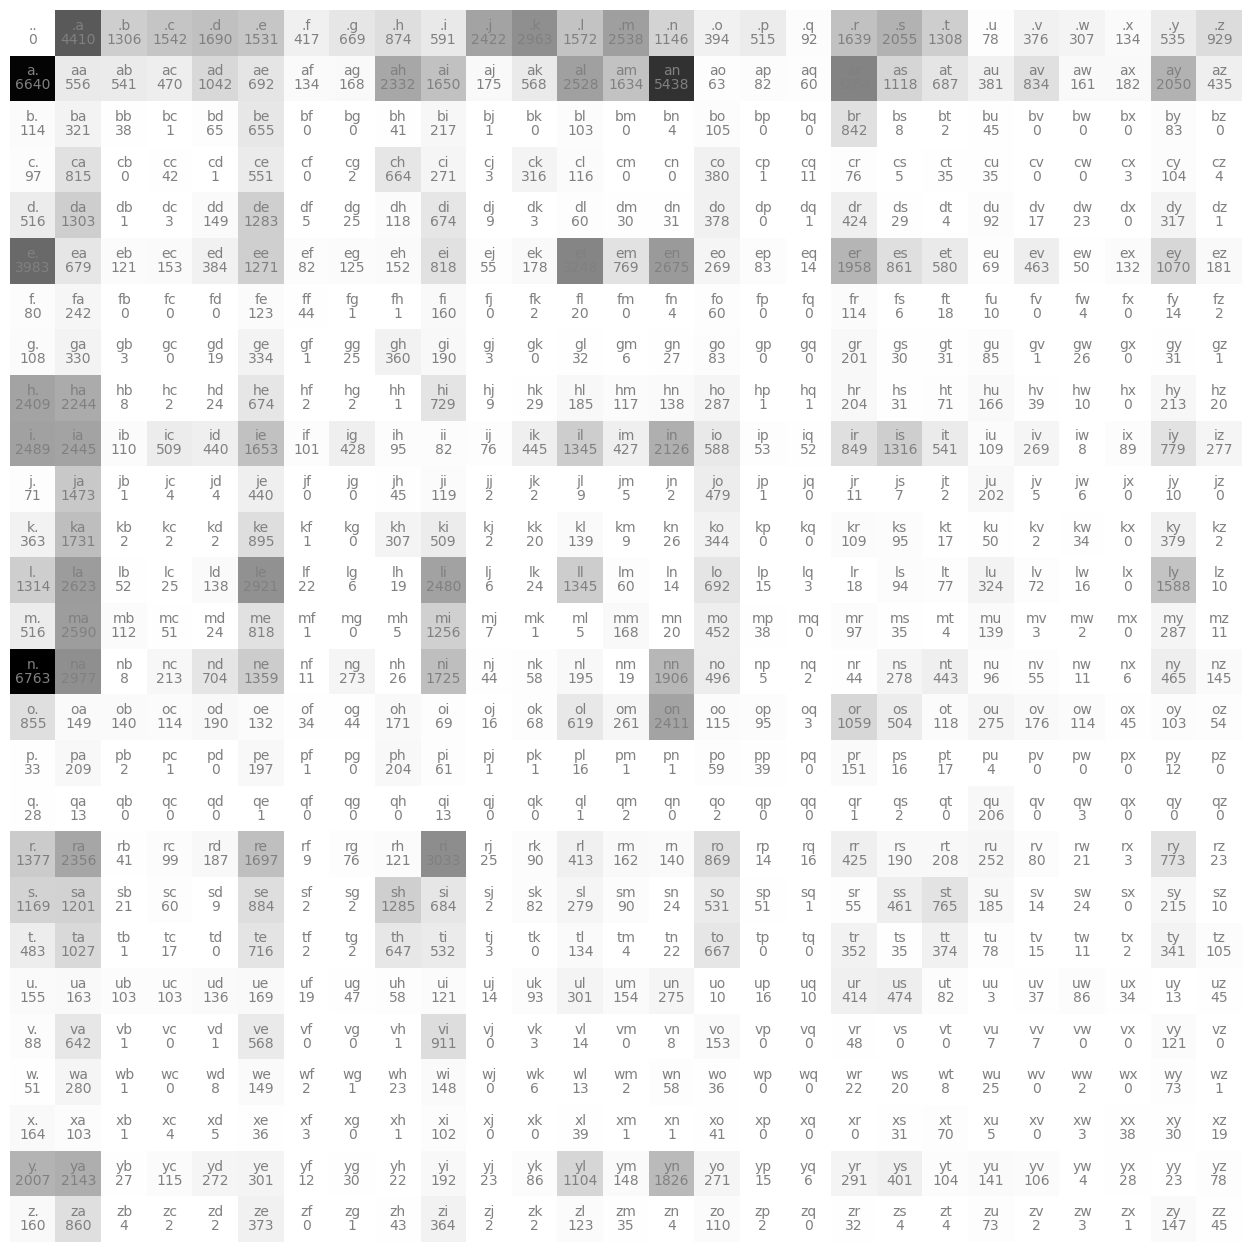

In [48]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='binary')
for i in range(27):
    for j in range(27):
        chstr = itos[i]+itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off');